## Imports

In [72]:
#pandas/numpy
import pandas as pd
import numpy as np

#loading data
import bz2
import json

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import wordcloud
from PIL import Image

#math operations
import math

#statistics
from scipy import stats
#from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import statsmodels.formula.api as smf

#matching algorithm
import networkx as nx

#warnings
import warnings

#util functions 
from utils import gmean_occupations, visualize_by_occupation, quotes_by_gender, unique_speaker_per_gender, get_champlex

#count in collection
from collections import Counter

#ignore future warnings
warnings.filterwarnings('ignore')

## Dataset


In [73]:
DATA_FOLDER = 'data/'
QUOTES_DATA = DATA_FOLDER + 'data_observational.json.bz2'

## Dictionnaries

In [74]:
DICTIONNARY_FOLDER = DATA_FOLDER + 'dictionnaries/'
DICT_OCCUPATIONS = DICTIONNARY_FOLDER + 'occupations_categories.json'
DICT_DEGREES = DICTIONNARY_FOLDER + 'degrees_categories.json'

## Load the data

In [75]:
quotes = pd.read_json(QUOTES_DATA)

In [76]:
with open(DICT_OCCUPATIONS) as f:
    dict_occupations = json.load(f)

In [77]:
with open(DICT_DEGREES) as f:
    dict_degrees = json.load(f)

# 1. Some preprocessing again

In [78]:
def translate(my_list, my_dict):
    """Allows to transform a list of items into a list of corresponding categories. 
    The list returned contains uniques category (the duplicates are removed).
    
    Parameters
    ----------
    my_list: the list to be translated
    my_dict: the dictionnary according which we want to translate the list
    
    Returns
    --------
    list of uniques categories"""
    translated_list = []
    for i in my_list:
        if i in my_dict.keys():
            translated_list.append(my_dict[i])
        else:
            translated_list.append('Others')
    #Drop duplicates
    return (list(set(translated_list)))
    
        

Now, we replace the occupations and academic degrees by more general categories

In [79]:
quotes['occupation'] = quotes['occupation'].apply(lambda x: translate(x, dict_occupations))

In [80]:
quotes['academic_degree'] = quotes['academic_degree'].apply(lambda x: translate(x, dict_degrees))

Prepare the dataset for propensity scores calculations:

In [81]:
print('Our dataset contains', quotes.shape[0], 'quotes from female speakers.')

Our dataset contains 1761820 quotes from female speakers.


Now, we want to calculate the propensity scores of each speaker. To do that, we need to group the quotations by speakers, and to recover some information about them.

In [82]:
grouped_speakers = quotes.groupby(['qids', 'label'])

After having grouped the quotations per speaker, we take the attributes corresponding to the first quotation: these attributes are immutable (the academic degree, the occupation, the speaker name and the gender), thus we can recover it from the first quotation.

In [83]:
attributes_immutable = grouped_speakers.first().reset_index().drop(['year', 
                                                                   'quotation', 'numOccurrences', 'age'], axis = 1)
attributes_immutable

,qids,label,speaker,gender,occupation,academic_degree
0,Q1000727,0,Ruslan Galitsky,male,[Military & Order],[candidate]
1,Q100230,0,Ludger Kühnhardt,male,[Teaching & Education],[doctor]
2,Q100308,1,Joachim Weimann,male,"[Literature, Teaching & Education, Social Scie...",[doctor]
3,Q1006191,1,F. Földényi,male,"[Literature, Service, Teaching & Education, Ar...",[Others]
4,Q100749,0,Clemens Fuest,male,"[Teaching & Education, Social Sciences & Ethno...",[doctor]
...,...,...,...,...,...,...
9343,Q996967,1,Diane Coyle,female,"[Teaching & Education, Social Sciences & Ethno...",[doctor]
9344,Q99818,0,Holger Afflerbach,male,"[Literature, Teaching & Education, Historian]",[doctor]
9345,Q99860,0,Ottmar Edenhofer,male,"[Teaching & Education, Social Sciences & Ethno...","[doctor, bachelor]"
9346,Q99860,1,Ottmar Edenhofer,male,"[Teaching & Education, Social Sciences & Ethno...","[doctor, bachelor]"


Now we will calculate the number of quotes per speaker, as well as the number of occurrences per speaker. We also put the age of the speaker to the median age of all its quotations. 

In [84]:
#Get the number of unique quotes per speaker
quotations_per_speaker = grouped_speakers['quotation'].count().reset_index(name='nb_quotes')

#Get the number of total occurrences of the speaker
occurrences_per_speaker = grouped_speakers['numOccurrences'].sum().reset_index(name='nb_occurrences')

#Get the median age of the speaker if she talks many times
age_per_speaker = grouped_speakers['age'].median().reset_index(name='age')

In [85]:
attributes_mutable = pd.merge(pd.merge(quotations_per_speaker, occurrences_per_speaker, on = ['qids', 'label']), 
                              age_per_speaker, on = ['qids', 'label'])
attributes_mutable.head()

,qids,label,nb_quotes,nb_occurrences,age
0,Q1000727,0,1,2,44.0
1,Q100230,0,1,1,59.0
2,Q100308,1,1,1,63.0
3,Q1006191,1,1,1,67.0
4,Q100749,0,300,1654,48.0


In [86]:
data_per_speaker = pd.merge(attributes_immutable, attributes_mutable, on = ['qids', 'label'])

Hot one encoding

In [87]:
dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)

In [88]:
dummies_gender = pd.get_dummies(data_per_speaker['gender'])

In [89]:
##C'est sombre mais get_dummies cree une colomn 'Others' donc en attendant de comprendre pq:
dummies_occ.drop(['Others'], axis = 1, inplace = True)
dummies_degree.drop(['Others'], axis = 1, inplace = True)

In [90]:
#Parce que la regression aime pas les espaces dans les noms de variables, ni les "&"
dummies_occ.columns = dummies_occ.columns.str.replace(" ", "_")
dummies_occ.columns = dummies_occ.columns.str.replace("&", "and")
dummies_degree.columns = dummies_degree.columns.str.replace(" ", "_")

In [91]:
data_features = pd.merge(pd.merge(data_per_speaker, dummies_occ, left_index = True, right_index = True), dummies_degree, left_index = True, right_index = True)
data_features = pd.merge(data_features, dummies_gender, left_index = True, right_index = True)

Before calculating the propensity scores, we should standardize the continuous features. Let's look at their distributions in order to choose an appropriate standardization. 

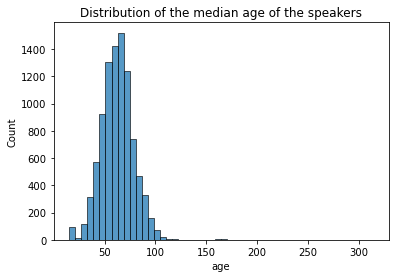

In [92]:
ax = sns.histplot(data_features['age'], bins = 50)
ax.set_title("Distribution of the median age of the speakers");

The distribution of the age seems to follow a gaussian distribution, thus, we will standardize it.

In [93]:
data_features['age'] = (data_features['age'] - data_features['age'].mean())/data_features['age'].std()
data_features.head(2)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male
0,Q1000727,0,Ruslan Galitsky,male,[Military & Order],[candidate],1,2,-1.109912,0,...,1,0,0,0,0,0,0,0,0,1
1,Q100230,0,Ludger Kühnhardt,male,[Teaching & Education],[doctor],1,1,-0.198774,0,...,0,0,1,0,0,0,0,0,0,1


Now the dataset is ready for the propensity scores calculation and matching (petit rappel de la théorie ici serait good!)

# 2. Create a balanced dataset to reduce bias

Now the dataset is ready for the observational study: pair identical people, propensity scores calculation and matching (petit rappel de la théorie ici!)

First, we know that some speakers might appear before and after the #MeToo movement. We decide to pair them up, because the goal is to match 2 identical person in terms of their observal covariates, but here, we already know that they are the same person! With just a few years more. But we assume that the difference in age in minor compared to the fact that all other covariates are exaclty the same, and not only the observable ones, since it is the same person!
Thus, we first pair the identical speakers that appear in both groups (control and treated). Then, for the others (i.e, the speakers who speak ONLY before the movement or ONLY after), we will use the method of propensity scores calculation based on the observable covariates = `age`, `occupation`, `academic_degree`.

## Pair up identical speakers

In [94]:
print("Number of speakers speaking both before and after",
      data_features[data_features['qids'].duplicated(keep = 'first') == True].shape[0])

Number of speakers speaking both before and after 3363


In [95]:
data_features.drop(['academic_degree', 'occupation'], axis = 1, inplace = True)

In [96]:
speakers_twice = data_features[data_features['qids'].duplicated(keep = False) == True]

## Pair up non-identical speakers

In [97]:
speakers_once = pd.concat([data_features,speakers_twice])

In [98]:
speakers_once.drop_duplicates(keep = False, inplace = True)

In [99]:
print('Now, we will try to pair up the other speakers, they are:', speakers_once.shape[0])

Now, we will try to pair up the other speakers, they are: 2622


### Propensity scores calculation

In [100]:
occupations_for_regression = ['C('+ str(x)+ ')' for x in dummies_occ.columns.tolist()]

In [101]:
degrees_for_regression = ['C('+ str(x)+ ')' for x in dummies_degree.columns.tolist()]

In [102]:
def create_formula_from_list_categories(my_list):
    list_for_regression = ['C('+ str(x)+ ')' for x in my_list]
    formula = ''
    for i in list_for_regression:
        formula += i
        if i != list_for_regression[-1]:
            formula += ' + '
    return formula
    

In [103]:
formula_occupations = create_formula_from_list_categories(dummies_occ.columns.tolist())

In [104]:
formula_degrees = create_formula_from_list_categories(dummies_degree.columns.tolist())

In [105]:
mod = smf.logit(formula='label ~  age + ' + formula_occupations + ' + ' + formula_degrees + '+ C(female)', data=speakers_once)

res = mod.fit(maxiter = 100)

# Extract the estimated propensity scores
speakers_once['Propensity_score'] = res.predict()

print(res.summary())

         Current function value: 0.682113
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 2622
Model:                          Logit   Df Residuals:                     2581
Method:                           MLE   Df Model:                           40
Date:                Fri, 10 Dec 2021   Pseudo R-squ.:                 0.01480
Time:                        11:19:48   Log-Likelihood:                -1788.5
converged:                      False   LL-Null:                       -1815.4
Covariance Type:            nonrobust   LLR p-value:                   0.07196
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.0424      0.175     -0.242      0.809      -0

# 3. Do women in general speak more after #MeToo?

## Matching balanced by gender

In [106]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [107]:
speakers_once.head(2)

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male,Propensity_score
0,Q1000727,0,Ruslan Galitsky,male,1,2,-1.109912,0,0,0,...,0,0,0,0,0,0,0,0,1,0.360498
1,Q100230,0,Ludger Kühnhardt,male,1,1,-0.198774,0,0,0,...,0,1,0,0,0,0,0,0,1,0.485614


In [108]:
"""# Separate the treatment and control groups
treatment_df = speakers_once[speakers_once['label'] == 1]
control_df = speakers_once[speakers_once['label'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        # Adds an edge only if the individuals have the same gender
        if (control_row['gender'] == treatment_row['gender']):
            similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)""";

In [109]:
"""matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_speakers_once = speakers_once.loc[matched]
balanced_speakers = pd.concat([balanced_speakers_once, speakers_twice])""";

In [110]:
"""##Pour éviter de run again le matching 
balanced_speakers.to_json(DATA_FOLDER + 'results/balanced_dataset_gender.json.bz2')""";

In [111]:
"""#On sauvegarde aussi les valeurs de paires
textfile = open("matching_by_gender.txt", "w")
for element in matching:
    textfile.write(str(element) + "\n")
textfile.close()""";

## Results

In [112]:
DATA_FOLDER_RESULT = 'data/results/'
BALANCED_DATA_BY_GENDER = DATA_FOLDER_RESULT + 'balanced_dataset_by_gender.json.bz2'
BALANCED_DATA_FEMALE = DATA_FOLDER_RESULT + 'balanced_dataset_female.json.bz2'


In [113]:
balanced_all_genders = pd.read_json(BALANCED_DATA_BY_GENDER)
balanced_female = pd.read_json(BALANCED_DATA_FEMALE)

In [114]:
male_balanced = balanced_all_genders[balanced_all_genders['gender'] == 'male']
fmale_balanced = balanced_all_genders[balanced_all_genders['gender'] == 'female']

male_before_metoo = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'male')]
#proportion nombre d'occurrences de citations par speaker homme avant me too, par rapport au nombre total d'occurences sur tous les hommes
prop_male_before =  male_before_metoo['nb_occurrences']/(male_balanced['nb_occurrences'].sum())

male_after_metoo = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'male')]
#proportion nombre d'occurrences de citations par speaker homme après me too, par rapport au nombre total d'occurences sur tous les hommes
prop_male_after=  male_after_metoo['nb_occurrences']/(male_balanced['nb_occurrences'].sum())

fmale_before_metoo = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'female')]
#proportion nombre d'occurrences de citations par speaker femme avant me too, par rapport au nombre total d'occurences sur tous les hommes
prop_fmale_before =  fmale_before_metoo['nb_occurrences']/(fmale_balanced['nb_occurrences'].sum())

fmale_after_metoo = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'female')]
#proportion nombre d'occurrences de citations par speaker femme après me too, par rapport au nombre total d'occurences sur tous les hommes
prop_fmale_after=  fmale_after_metoo['nb_occurrences']/(fmale_balanced['nb_occurrences'].sum())

In [115]:
#Mean
print('Mean occurrences before #MeToo, per women : ',fmale_before_metoo['nb_occurrences'].mean() ,', and per men : ',male_before_metoo['nb_occurrences'].mean())
print('Mean occurrences after #MeToo, per women : ', fmale_after_metoo['nb_occurrences'].mean(),', and per men : ',male_after_metoo['nb_occurrences'].mean())


#Median
print('Median occurrences before #MeToo, per women : ',fmale_before_metoo['nb_occurrences'].median() ,', and per men : ',male_before_metoo['nb_occurrences'].median())
print('Median occurrences after #MeToo, per women : ',fmale_after_metoo['nb_occurrences'].median() ,', and per men : ',male_after_metoo['nb_occurrences'].median())


#Geometric mean
print('Geometric mean occurrences before #MeToo, per women : ',stats.mstats.gmean(fmale_before_metoo['nb_occurrences'], dtype=None),', and per men : ',stats.mstats.gmean(male_before_metoo['nb_occurrences'], dtype=None))
print('Geometric mean occurrences after #MeToo, per women : ',stats.mstats.gmean(fmale_after_metoo['nb_occurrences'],dtype=None) ,', and per men : ',stats.mstats.gmean(male_after_metoo['nb_occurrences'],dtype=None))


resume=[]
resume.append(["Female","Before #MeToo", fmale_before_metoo['nb_occurrences'].mean(),
               fmale_before_metoo['nb_occurrences'].median(),stats.mstats.gmean(fmale_before_metoo['nb_occurrences'], dtype=None)])
              
resume.append(["Male","Before #MeToo", male_before_metoo['nb_occurrences'].mean(),
               male_before_metoo['nb_occurrences'].median(),stats.mstats.gmean(male_before_metoo['nb_occurrences'], dtype=None)])

resume.append(["Female","After #MeToo", fmale_after_metoo['nb_occurrences'].mean(),
               fmale_after_metoo['nb_occurrences'].median(),stats.mstats.gmean(fmale_after_metoo['nb_occurrences'], dtype=None)])
              
resume.append(["Male","After #MeToo", male_after_metoo['nb_occurrences'].mean(),
               male_after_metoo['nb_occurrences'].median(),stats.mstats.gmean(male_after_metoo['nb_occurrences'], dtype=None)])


Res_mean_med_gmean=pd.DataFrame(resume)  
Res_mean_med_gmean.rename(columns={0: 'Gender', 1: 'Period', 2: 'Mean of Occurences', 
                                   3:"Median of Occurences",4: 'Geometric Mean of Occurences'}, inplace=True)

Res_mean_med_gmean

Mean occurrences before #MeToo, per women :  852.3845371312309 , and per men :  1050.228084638637
Mean occurrences after #MeToo, per women :  973.677517802645 , and per men :  1777.295960428689
Median occurrences before #MeToo, per women :  13.0 , and per men :  11.0
Median occurrences after #MeToo, per women :  19.0 , and per men :  15.0
Geometric mean occurrences before #MeToo, per women :  17.428753029330508 , and per men :  15.82947855571642
Geometric mean occurrences after #MeToo, per women :  29.190302412873155 , and per men :  21.651457601949694


,Gender,Period,Mean of Occurences,Median of Occurences,Geometric Mean of Occurences
0,Female,Before #MeToo,852.384537,13.0,17.428753
1,Male,Before #MeToo,1050.228085,11.0,15.829479
2,Female,After #MeToo,973.677518,19.0,29.190302
3,Male,After #MeToo,1777.295960,15.0,21.651458


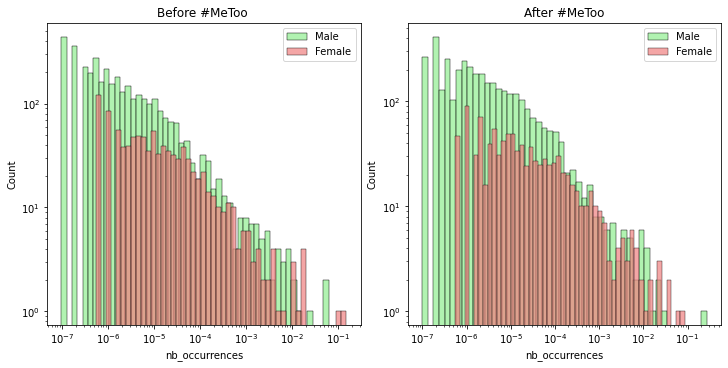

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2,constrained_layout=True, figsize=(10, 5))
sns.histplot(ax = axs[0], 
                 data = prop_male_before, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightgreen', 
                 alpha = 0.7, 
                 legend = True,
                 stat = 'count')
sns.histplot(ax = axs[0],
                 data = prop_fmale_before, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightcoral', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'count')
axs[0].set_title('Before #MeToo ')
axs[0].legend(labels=['Male','Female']);
axs[0].set(yscale = 'log')
sns.histplot(ax = axs[1],
                 data = prop_male_after, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightgreen', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'count')
sns.histplot(ax = axs[1],
                 data = prop_fmale_after, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightcoral', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'count')
axs[1].set_title('After #MeToo')
axs[1].legend(labels=['Male','Female']);
axs[1].set(yscale = 'log')

plt.show()

In [46]:
#converts my list into a dict, useful for generation of worldcloud : 
def Convert(lst):
    res_dct = {lst[i][0]: lst[i][0+1] for i in range(0, len(lst))}
    return res_dct

In [47]:
def create_Worldcloud(df,mask_image):
    font_path = 'data/true_south/True South.ttf'
    tupl = [tuple(x) for x in df.values]
    dict_ready = Convert(tupl)
    mask_ = np.array(Image.open(mask_image))
    df_wordcloud = wordcloud.WordCloud(font_path = font_path,width = 500,max_font_size = 300,height=500 ,background_color="white",relative_scaling = 0.4, max_words=500, mask=mask_,contour_width=3, contour_color='peru').generate_from_frequencies(dict_ready)
    return df_wordcloud

In [48]:
def get_occup (rowss,columns_occ) : 
    list_occ = columns_occ.columns.to_list()
    rowss['occupation']= []
    for i in range(0,len(list_occ)) : 
        if (rowss[list_occ[i]] == 1) :
            rowss['occupation'].append(list_occ[i])
    return (rowss)

In [49]:
balanced_all_genders= balanced_all_genders.apply(lambda row : get_occup(row,dummies_occ),axis=1)

In [50]:
df_occ_female_before = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'female')].occupation.explode(ignore_index=True)
df_occ_female_after = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'female')].occupation.explode(ignore_index=True)
df_occ_male_before = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'male')].occupation.explode(ignore_index=True)
df_occ_male_after = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'male')].occupation.explode(ignore_index=True)

In [51]:
#Compute the reprensented occupations for female speakers before me too
most_occ_female_before=pd.DataFrame(Counter(df_occ_female_before).most_common(),columns =['occupation', 'nb_occurences'])
most_occ_male_before = pd.DataFrame(Counter(df_occ_male_before).most_common(),columns =['occupation', 'nb_occurences'])
most_occ_male_before.dropna(inplace=True)
print(most_occ_female_before.head())
print(most_occ_male_before.head())

#Compute the reprensented occupations for female speakers after me too
most_occ_female_after=pd.DataFrame(Counter(df_occ_female_after).most_common(),columns =['occupation', 'nb_occurences'])
most_occ_male_after=pd.DataFrame(Counter(df_occ_male_after).most_common(),columns =['occupation', 'nb_occurences'])
most_occ_male_after.dropna(inplace=True)
print(most_occ_female_after.head())
print(most_occ_male_after.head())

                      occupation  nb_occurences
0         Teaching_and_Education            332
1                     Government            257
2                      Scientist            234
3                     Literature            193
4  Social_Sciences_and_Ethnology            141
                      occupation  nb_occurences
0         Teaching_and_Education           1439
1                     Government           1004
2                      Scientist            908
3  Social_Sciences_and_Ethnology            777
4                     Literature            677
                      occupation  nb_occurences
0         Teaching_and_Education            316
1                     Government            263
2                      Scientist            244
3                     Literature            179
4  Social_Sciences_and_Ethnology            140
                      occupation  nb_occurences
0         Teaching_and_Education           1448
1                     Government        

In [52]:
most_occ_female_before['occupation'].replace({'Teaching_and_Education':'Teaching','Social_Sciences_and_Ethnology': 'Social_sciences','Media_and_Journalism':'Media'},inplace=True)
most_occ_female_after['occupation'].replace({'Teaching_and_Education':'Teaching','Social_Sciences_and_Ethnology': 'Social_sciences','Media_and_Journalism':'Media'},inplace=True)
most_occ_male_before['occupation'].replace({'Teaching_and_Education':'Teaching','Social_Sciences_and_Ethnology': 'Social_sciences','Media_and_Journalism':'Media'},inplace=True)
most_occ_male_after['occupation'].replace({'Teaching_and_Education':'Teaching','Social_Sciences_and_Ethnology': 'Social_sciences','Media_and_Journalism':'Media'},inplace=True)

In [53]:
#before me too
Worldcloud_before_fem = create_Worldcloud(most_occ_female_before, 'data/female.png')
Worldcloud_before_mal = create_Worldcloud(most_occ_male_before,'data/male.png')

#after me too
Worldcloud_after_fem = create_Worldcloud(most_occ_female_after,'data/female.png')
Worldcloud_after_mal = create_Worldcloud(most_occ_male_after,'data/male.png')

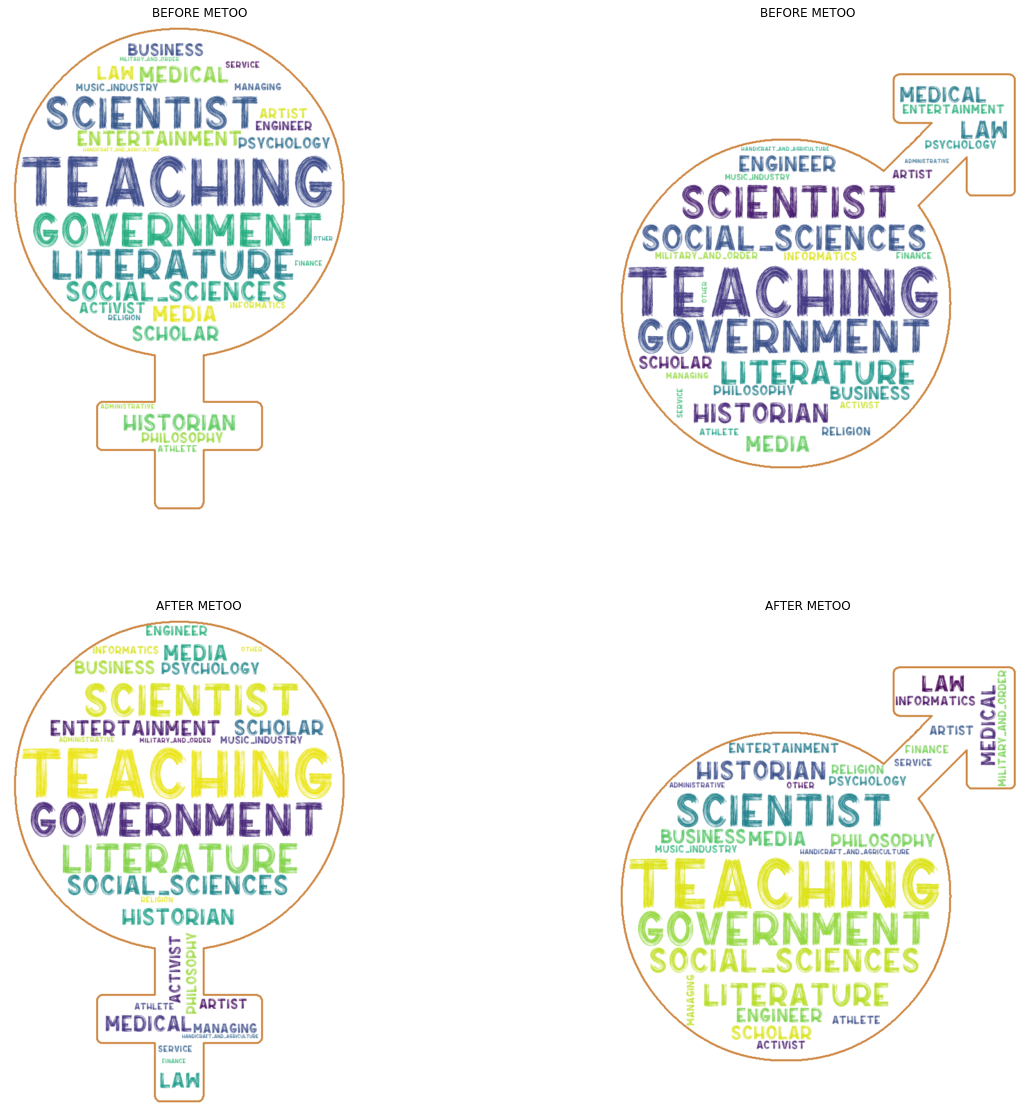

In [54]:
fig,ax = plt.subplots(2,2, figsize=(20,20))
ax[0,0].imshow(Worldcloud_before_fem, cmap=plt.cm.gray, interpolation="bilinear")
ax[0,0].axis("off")
ax[0,0].set_title('BEFORE METOO')
ax[0,1].imshow(Worldcloud_before_mal, cmap=plt.cm.gray, interpolation="bilinear")
ax[0,1].set_title('BEFORE METOO')
ax[0,1].axis("off")
ax[1,0].imshow(Worldcloud_after_fem, cmap=plt.cm.gray, interpolation="bilinear")
ax[1,0].set_title('AFTER METOO')
ax[1,0].axis("off")
ax[1,1].imshow(Worldcloud_after_mal, cmap=plt.cm.gray, interpolation="bilinear")
ax[1,1].set_title('AFTER METOO')
ax[1,1].axis("off")
plt.show()

# 4. Are some categories of occupations more represented among female speakers after #MeToo ?

Now, we will try to analyze if some categories of occupations are more represented after the movement than before among women. Here again, we will compare with the evolution of men's speech. To do that, we will focus on the 8 main represented categories in the entire dataset.

In [55]:
main_categories = data_features[dummies_occ.columns.tolist()].sum().sort_values(ascending = False).head(8)
print('The 8 categories of occupations most represented in the dataset are:', main_categories.index.to_list())

The 8 categories of occupations most represented in the dataset are: ['Teaching_and_Education', 'Government', 'Scientist', 'Social_Sciences_and_Ethnology', 'Literature', 'Historian', 'Law', 'Media_and_Journalism']


## Matching by categories

Such as in the previous section, we will match pairs of speakers according to their proprensity scores calculated above. We match exactly one speaker from the control group (speaker before #MeToo) with one speaker from the treated group (after #MeToo). We repeat the matching for each category, since we match only speakers of same gender and of same value for the category we want to analyze, i.e for example if we analyze the evolution of scientists' speech, we will pairs scientist women together, non-scientists women together, men scientists together and men non-scientists together.  

In [56]:
def match_by_category(df, category):
    # Separate the treatment and control groups
    treatment_df = df[df['label'] == 1]
    control_df = df[df['label'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            # Adds an edge only if the individuals have the same gender
            if (control_row['gender'] == treatment_row['gender'])  and (control_row[category] == 
                                                                        treatment_row[category]):
                similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    
    balanced_df = df.loc[matched,:]
    balanced_df.to_json(DATA_FOLDER + f'results/balanced_{category}.json.bz2')

In [57]:
#Cellule a decommenter le jour du rendu 
"""for category in main_categories.index:
    match_by_category(speakers_once, category)""";

## Results

### Teaching and education

In [58]:
balanced_teaching = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Teaching_and_Education.json.bz2'), 
                               speakers_twice])

Let's look at sample sizes.

In [59]:
pd.crosstab(balanced_teaching.label, [balanced_teaching.gender, balanced_teaching.Teaching_and_Education])

gender                 female       male      
Teaching_and_Education      0    1     0     1
label                                         
0                         651  321  2200  1439
1                         651  321  2200  1439

In [60]:
gmean_occupations(balanced_teaching, 'Teaching_and_Education', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                              Before #MeToo    After #MeToo
--------------------------  ---------------  --------------
Non Teaching_and_Education          8.92368         12.9206
Teaching_and_Education              7.25589         10.0746


Female speakers
                              Before #MeToo    After #MeToo
--------------------------  ---------------  --------------
Non Teaching_and_Education         10.248           17.4888
Teaching_and_Education              7.94348         10.9829


### Government

In [61]:
balanced_government = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Government.json.bz2'), 
                               speakers_twice])

Let's take a look at sample sizes.

In [62]:
pd.crosstab(balanced_government.label, [balanced_government.gender, balanced_government.Government])

gender     female       male      
Government      0    1     0     1
label                             
0             726  257  2635  1004
1             726  257  2635  1004

Note: the distributions are skewed. Thus we represent them on a log-log scale.

In [63]:
gmean_occupations(balanced_government, 'Government', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                  Before #MeToo    After #MeToo
--------------  ---------------  --------------
Non Government           7.0203         9.91399
Government              12.451         18.0582


Female speakers
                  Before #MeToo    After #MeToo
--------------  ---------------  --------------
Non Government          7.89492         11.7085
Government             14.7783          28.1394


In [64]:
##TODO peut être: trouver un test statistique qui peut comparer des skewed distributions? 

### Scientist


In [116]:
balanced_scientist = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Scientist.json.bz2'), 
                               speakers_twice])

### Social science and ethnology

In [117]:
balanced_social_sciences = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Social_Sciences_and_Ethnology.json.bz2'), 
                               speakers_twice])

### Literature

In [118]:
balanced_literature = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Literature.json.bz2'), 
                               speakers_twice])

### Historian

In [119]:
balanced_historian = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Historian.json.bz2'), 
                               speakers_twice])

### Law


In [120]:
balanced_law = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Law.json.bz2'), 
                               speakers_twice])

### Media and Journalism

In [121]:
balanced_media = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Media_and_Journalism.json.bz2'), 
                               speakers_twice])

### General overview by category ####

In [122]:
cat=[balanced_teaching, balanced_government, balanced_scientist, balanced_social_sciences,balanced_literature,
    balanced_historian, balanced_law, balanced_media]
cat_names=["Teaching_and_Education", "Government", "Scientist", "Social_Sciences_and_Ethnology","Literature",
    "Historian", "Law", "Media_and_Journalism"]
i=0
befF=[]
afterF=[]
befM=[]
afterM=[]
for c in cat:
    befF.append([cat_names[i],
                 stats.mstats.gmean(c[(c['label'] == 0) & (c['female'] == 1) & (c[cat_names[i]] == 1)]['nb_quotes']),
                 (c[(c['label'] == 0) & (c['female'] == 1) & (c[cat_names[i]] == 1)]['nb_occurrences']).sum(),
                 "Before #MeToo","Female"])
    
    afterF.append([cat_names[i],
                   stats.mstats.gmean(c[(c['label'] == 1) & (c['female'] == 1)& (c[cat_names[i]] == 1)]['nb_quotes']),
                   (c[(c['label'] == 1) & (c['female'] == 1)& (c[cat_names[i]] == 1)]['nb_occurrences']).sum(),
                    "After #MeToo","Female"])
    
    befM.append([cat_names[i],
                 stats.mstats.gmean(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_quotes']),
                 (c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_occurrences']).sum(),
                 "Before #MeToo","Male"])
    
    afterM.append([cat_names[i],
                   stats.mstats.gmean(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_quotes']),
                   (c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_occurrences']).sum(),
                   "After #MeToo","Male"])
    i+=1    

In [123]:
dfF=pd.DataFrame(befF+afterF)
dfF.rename(columns={0: 'Occupation', 1: 'gmean', 2: 'Occurences', 3:"Label",4: 'Gender'}, inplace=True)
dfF.replace({"Teaching_and_Education": "Teaching",
             "Social_Sciences_and_Ethnology":"Social_Sciences",
            "Media_and_Journalism":"Media"},inplace=True)

dfM=pd.DataFrame(befM+afterM)
dfM.rename(columns={0: 'Occupation', 1: 'gmean', 2: 'Occurences', 3:"Label",4: 'Gender'}, inplace=True)
dfM.replace({"Teaching_and_Education": "Teaching",
             "Social_Sciences_and_Ethnology":"Social_Sciences",
            "Media_and_Journalism":"Media"},inplace=True)


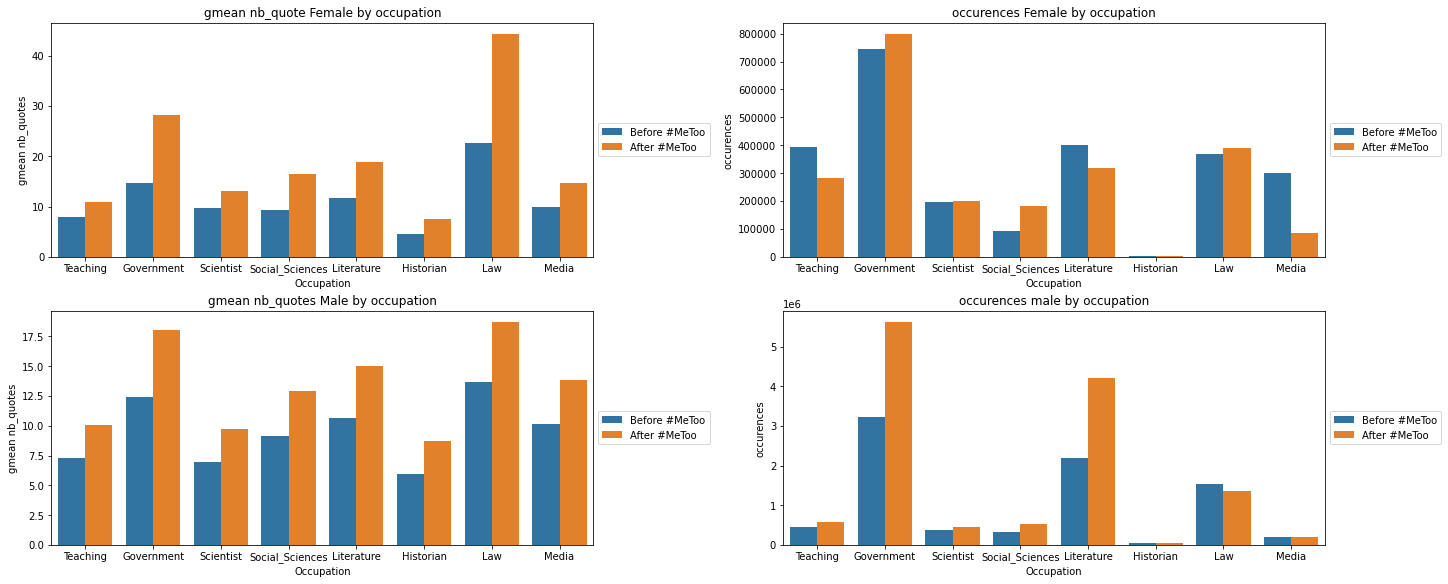

In [124]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(20, 8)) 

sns.barplot(ax=ax[0,0],x = dfF['Occupation'], y = dfF['gmean'], hue = dfF['Label'], data = dfF)
#ax.set(yscale="log");
ax[0,0].set(ylabel='gmean nb_quotes')
ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0,0].set_title('gmean nb_quote Female by occupation');

sns.barplot(ax=ax[1,0], x = dfM['Occupation'], y = dfM['gmean'], hue = dfM['Label'], data = dfM)
#ax.set(yscale="log");
ax[1,0].set(ylabel='gmean nb_quotes')
ax[1,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1,0].set_title('gmean nb_quotes Male by occupation');


sns.barplot(ax=ax[0,1],x = dfF['Occupation'], y = dfF['Occurences'], hue = dfF['Label'], data = dfF)
#ax.set(yscale="log");
ax[0,1].set(ylabel='occurences')
ax[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0,1].set_title('occurences Female by occupation');

sns.barplot(ax=ax[1,1],x = dfM['Occupation'], y = dfM['Occurences'], hue = dfM['Label'], data = dfM)
#ax.set(yscale="log");
ax[1,1].set(ylabel='occurences')
ax[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1,1].set_title('occurences male by occupation');